### Predicting COVID19 Mortality Rate in Sweden with SEIRD Epidimeological Model

Here I will do my best to fit the SEIRD epidemiological model to the available COVID19 data in Sweden. The math behind the SEIRD model can be found here https://www.idmod.org/docs/hiv/model-seir.html and it is very well explained in this great post https://towardsdatascience.com/simulating-compartmental-models-in-epidemiology-using-python-jupyter-widgets-8d76bdaff5c2. The model is based on the following ordinary differential equations of first order:

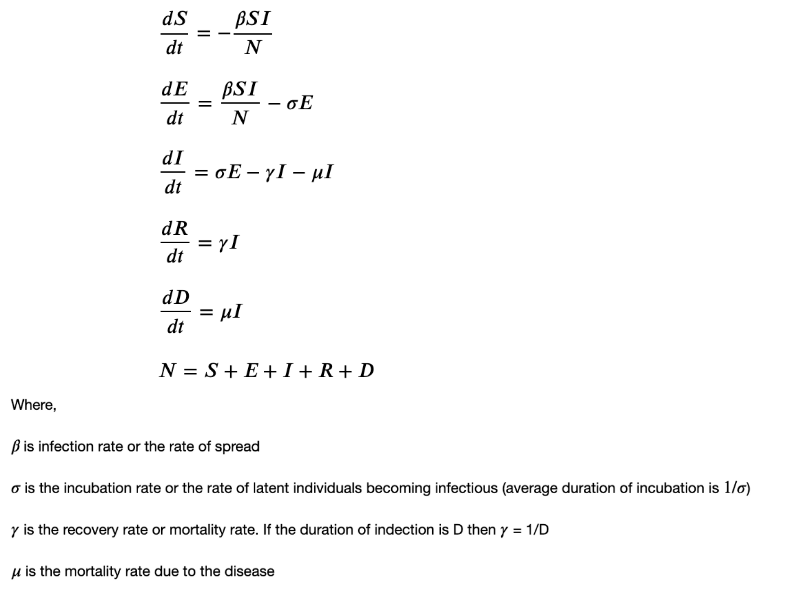

In [1]:
from IPython.display import Image
Image('/home/nikolay/Documents/Medium/COVID19/SEIRD_math.png', width=1000)

I start with reading and preparing the data for the analysis:

In [2]:
import os
import numpy as np
import pandas as pd

os.chdir('/home/nikolay/Documents/Medium/COVID19/')

deaths = pd.read_csv("time_series_covid19_deaths_global.csv")
deaths = deaths[deaths['Province/State'].isna()==True]
deaths.index = list(deaths['Country/Region'])
deaths = deaths.drop(['Province/State', 'Lat', 'Long', 'Country/Region'], axis = 1)
deaths = deaths.drop(list(deaths.columns[0:25]), axis = 1)
deaths.head()

,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,...,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,14,14,15,15,18,18,21,23,25,30
Albania,0,0,0,0,0,0,0,0,0,0,...,22,22,23,23,23,23,23,24,25,26
Algeria,0,0,0,0,0,0,0,0,0,0,...,193,205,235,256,275,293,313,326,336,348
Andorra,0,0,0,0,0,0,0,0,0,0,...,22,23,25,26,26,29,29,31,33,33
Angola,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


Here we define the system of differential equations and a function that solves them:

In [4]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

matplotlib.rcParams.update({'font.size': 22})

def define_odes(z, t, beta, sigma, gamma, mu):
    S, E, I, R, D = z
    N = S + E + I + R + D
    dSdt = -beta*S*I/N
    dEdt = beta*S*I/N - sigma*E
    dIdt = sigma*E - gamma*I - mu*I
    dRdt = gamma*I
    dDdt = mu*I
    derivatives = [dSdt, dEdt, dIdt, dRdt, dDdt]
    return derivatives

def solve_odes(t, init, params):
    initE, initI, initR, initN, initD = init
    beta, sigma, gamma, mu = params
    initS = initN - (initE + initI + initR + initD)
    result = odeint(define_odes, [initS, initE, initI, initR, initD], t, args=(beta, sigma, gamma, mu))
    return result

We will do fitting of the SEIRD model to the information about COVID19 caused deaths in Sweden for the number of days:

In [5]:
days_data = np.array(range(len(list(deaths.loc['Sweden'])))).reshape(-1,1)
days = len(days_data)

Here we define the optimization function:

In [8]:
def my_optim_func(parameters):
    initE = parameters[0]
    initI = parameters[1]
    initR = parameters[2]
    initN = parameters[3]
    initD = parameters[4]
    beta = parameters[5]
    sigma = parameters[6]
    gamma = parameters[7]
    mu = parameters[8]
    
    initial_conditions = [initE, initI, initR, initN, initD]
    params = [beta, sigma, gamma, mu]
    tspan = np.arange(0, days, 1)
    sol = solve_odes(tspan, initial_conditions, params)
    S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]
    return np.sqrt(np.sum((np.log10(D+1)-np.log10(np.array(list(deaths.loc['Sweden']))+1))**2)) / len(days_data)

Let us start the OLS fitting with respect to 9 fitting parameters:

In [9]:
from scipy import optimize
bnds = ((1, 100), (1, 100), (0, 0), (10e+6, 10e+6), (0, 0), (0, 10), (0, 10), (0, 10), (0, 10))
parameters_est = optimize.minimize(my_optim_func, [1, 0, 0, 10e+6, 0, 1, 1/5, 1/3, 0.008], 
                                   bounds = bnds, method = 'SLSQP')
parameters_est

     fun: 0.02225427546876638
     jac: array([-6.24044333e-05, -8.73056706e-05,  2.56113708e-08, -2.44472176e-08,
        8.35946365e-03,  4.17234842e-04,  9.46856802e-04, -1.43708149e-03,
        2.68910767e-02])
 message: 'Optimization terminated successfully.'
    nfev: 179
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([1.00011484e+00, 1.00017387e+00, 0.00000000e+00, 1.00000000e+07,
       0.00000000e+00, 1.04211091e+00, 1.98402279e-01, 2.90401734e-01,
       3.49697409e-03])

In [10]:
initE, initI, initR, initN, initD, beta, sigma, gamma, mu = parameters_est.x
print('initE = {0},\ninitI = {1},\ninitR = {2},\ninitN = {3},\ninitD = {4},\nbeta = {5},\nsigma = {6},\ngamma = {7},\nmu = {8}'.format(initE, initI, initR, initN, initD, beta, sigma, gamma, mu))

initE = 1.0001148449435628,
initI = 1.000173866773244,
initR = 0.0,
initN = 10000000.0,
initD = 0.0,
beta = 1.042110913441063,
sigma = 0.19840227871272817,
gamma = 0.2904017342342499,
mu = 0.00349697409019739


In [11]:
R0 = beta / gamma
R0

3.5885147731261613

In [13]:
days_data = np.array(range(len(list(deaths.loc['Sweden'])))).reshape(-1,1)
#days = len(days_data)
days = 120

initial_conditions = [initE, initI, initR, initN, initD]
params = [beta, sigma, gamma, mu]
tspan = np.arange(0, days, 1)
sol = solve_odes(tspan, initial_conditions, params)
S, E, I, R, D = sol[:, 0], sol[:, 1], sol[:, 2], sol[:, 3], sol[:, 4]

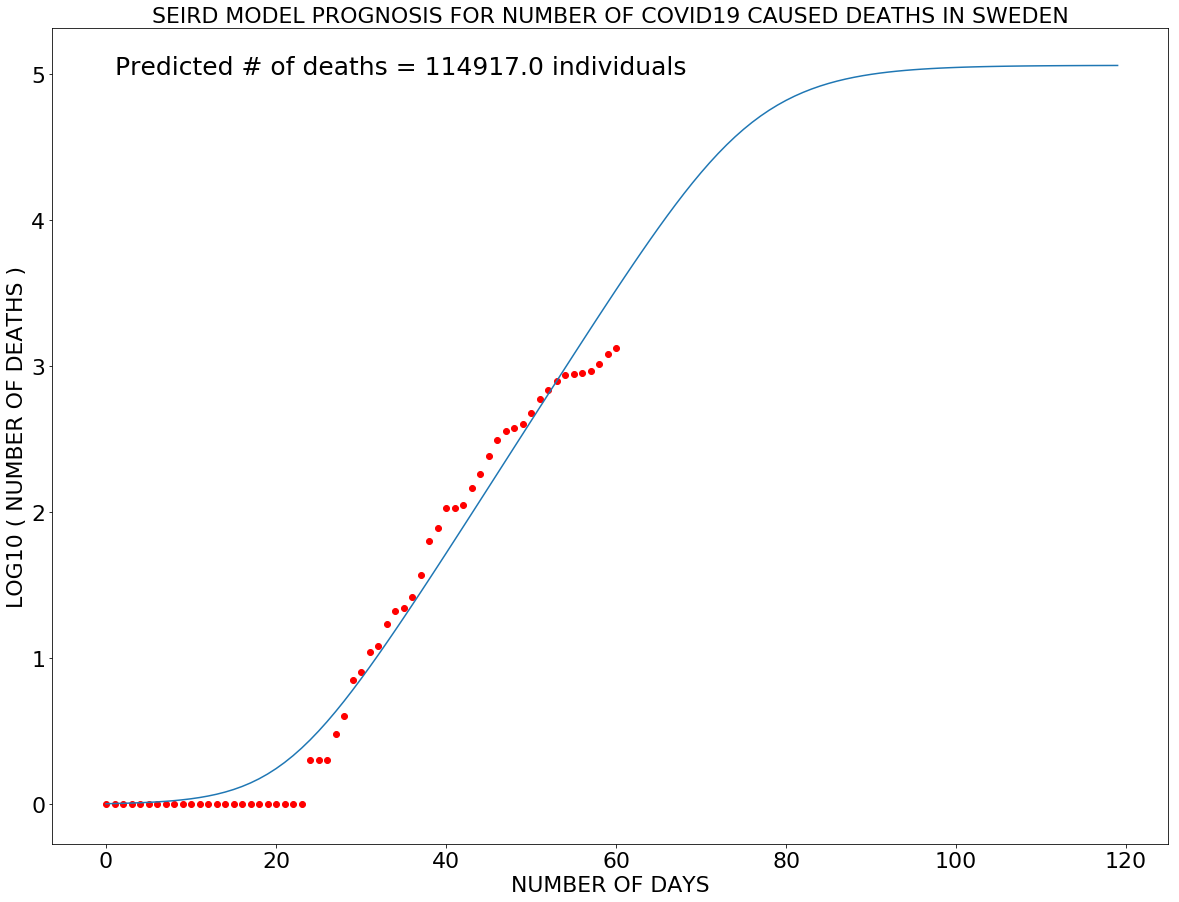

In [14]:
plt.figure(figsize=(20, 15))
plt.plot(tspan, np.log10(D + 1))
plt.scatter(days_data, np.log10(np.array(list(deaths.loc['Sweden'])) + 1), color = 'red')
#plt.plot(tspan, D)
#plt.scatter(days_data, np.array(list(deaths.loc['Sweden'])), color = 'red')
plt.xlabel('NUMBER OF DAYS', fontsize = 22)
plt.ylabel('LOG10 ( NUMBER OF DEATHS )', fontsize = 22)
plt.title('SEIRD MODEL PROGNOSIS FOR NUMBER OF COVID19 CAUSED DEATHS IN SWEDEN', fontsize = 22)
plt.text(1, 5, s='Predicted # of deaths = {} individuals'.format(np.round(D[-1],0)), fontsize = 25)
plt.show()